In [112]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
# Libraries for gif creation
import imageio
import os

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score,  mutual_info_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans, AffinityPropagation, Birch, DBSCAN, MeanShift, OPTICS, SpectralClustering
from sklearn.mixture import GaussianMixture
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [152]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [153]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels)) # Choosing unique cluster numbers/labels
    
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, # hue - division based on cluster
                    palette="colorblind", legend=False, 
                    hue_order=unique_labels) # order of the clusters the same as in unique
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in unique_labels:
        center = X[(labels == label)].mean(axis=0) # choose rows in X which have the same index as the label, take the mean across each column
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

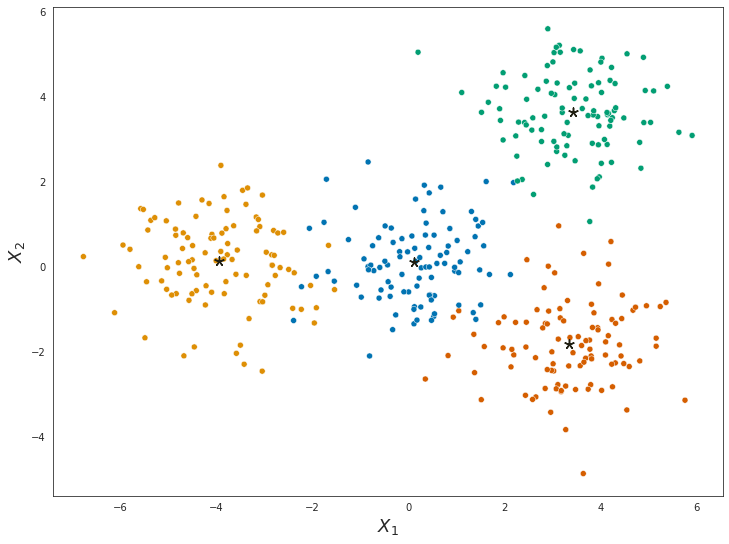

In [154]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [155]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False, animate=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
        self.animate = animate
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features) # n_clusters centroids with n_features
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False) # Choosing n_clusters indices 
            centroids = X[centroids_idx]
        filenames=[]
        # Итеративно двигаем центры
        for i in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.array(dists) # Convert list to an array
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=0) # Choose a minimum in each column
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
            
            if self.animate:
                # Create file name and append it to a list
                filename = f"your_dist_{i}.png"
                filenames.append(filename)
                
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.savefig(filename)
                plt.close()
                
                dur = [i/300 + 0.15 for i in range(self.max_iter+1, 1, -1)]
                with imageio.get_writer('tsne.gif', mode='I', duration = dur) as writer:
                    for index, filename in enumerate(filenames):
                        image = imageio.imread(filename)
                        writer.append_data(image)



        # Remove files
        for filename in set(filenames):
            os.remove(filename)   
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        # Посчитаем расстояния для всех объектов до каждого центроида
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.array(dists) # Convert list to an array
        # Для каждого объекта найдем, к какому центроиду он ближе
        cluster_labels = np.argmin(dists, axis=0) # Choose a minimum in each column            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера (n_samples,)
        """
        dist = np.linalg.norm(X-centroid, axis=1)   
        return dist
    
    
    def metrics(self, X, true_labels, pred_labels):
        """
        Возвращает метрики для кластеризации
            :param X: наши данные (n_samples, n_features)
            :param true_labels: настоящие метки кластеров
            :param pred_labels: предсказанные метки кластеров
        :return None: печатает метрики
        """
        
        # Silhouette Score
        print(f"Silhouette Score: {silhouette_score(X, pred_labels)}")
        # Rand score
        print(f"Rand score: {rand_score(true_labels, pred_labels)}")
        # Adjusted rand score
        print(f"Adjusted rand score: {adjusted_rand_score(true_labels, pred_labels)}")
        # Mutual Information
        print(f"Mutual information: {mutual_info_score(true_labels, pred_labels)}")
        # Adjusted mutual Information
        print(f"Adjusted mutual information: {adjusted_mutual_info_score(true_labels, pred_labels)}")
        # Calinski-Harabasz Index/Variance Ratio Criterion
        print(f"Calinski-Harabasz Index/Variance Ratio Criterion: {calinski_harabasz_score(X, pred_labels)}")
        # Davis-Bouldin index
        print(f"Davis-Bouldin index: {davies_bouldin_score(X, pred_labels)}")
        # Homogeneity, competness v-measure
        print(f"Homogeneity, completeness and v-measure: {homogeneity_completeness_v_measure(true_labels, pred_labels)}")
        
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

In [156]:
km_random = MyKMeans(4, init='random', max_iter=10, visualize=False, animate=True)

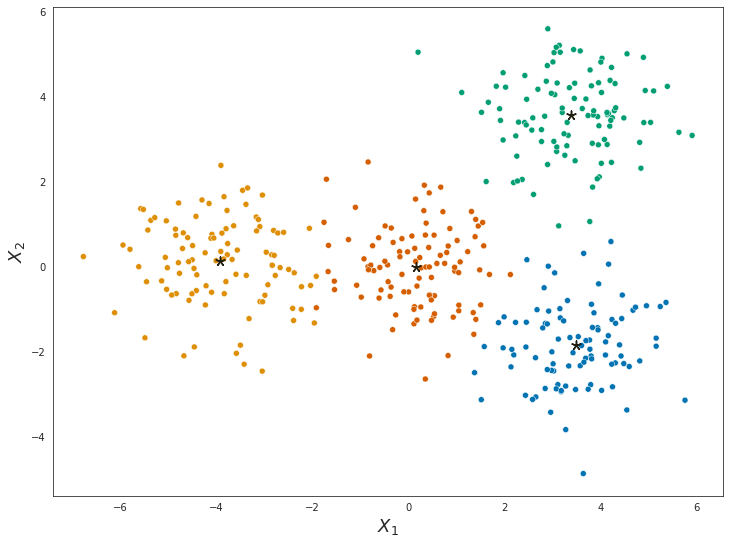

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [157]:
km_random.fit(X)

In [9]:
pred_labels = km_random.predict(X)

In [10]:
km_random.metrics(X, true_labels=true_labels, pred_labels=pred_labels)

Silhouette Score: 0.5643117184043004
Rand score: 0.9730827067669173
Adjusted rand score: 0.9278697796079957
Mutual information: 1.2557553505233132
Adjusted mutual information: 0.9051395864810662
Calinski-Harabasz Index/Variance Ratio Criterion: 932.1048591743721
Davis-Bouldin index: 0.5809362237888005
Homogeneity, completeness and v-measure: (0.9058360083848834, 0.9059994158301697, 0.9059177047387577)


In [11]:
km_sample = MyKMeans(4, init='sample', max_iter=10, visualize=False, animate=False)

In [12]:
km_sample.fit(X)

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [13]:
pred_labels = km_sample.predict(X)

In [14]:
km_sample.metrics(X, true_labels=true_labels, pred_labels=pred_labels)

Silhouette Score: 0.5643117184043004
Rand score: 0.9730827067669173
Adjusted rand score: 0.9278697796079957
Mutual information: 1.255755350523313
Adjusted mutual information: 0.9051395864810661
Calinski-Harabasz Index/Variance Ratio Criterion: 932.1048591743721
Davis-Bouldin index: 0.5809362237888005
Homogeneity, completeness and v-measure: (0.9058360083848833, 0.9059994158301696, 0.9059177047387575)


Here we have the same metrics, after so many iterations. When trying out on less than 300 iterations (e.g.), metrics defer a little bit but not by a lot. Sometimes `random` is better, sometimes `sample`.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [15]:
data = load_digits()
X, y = data.data, data.target

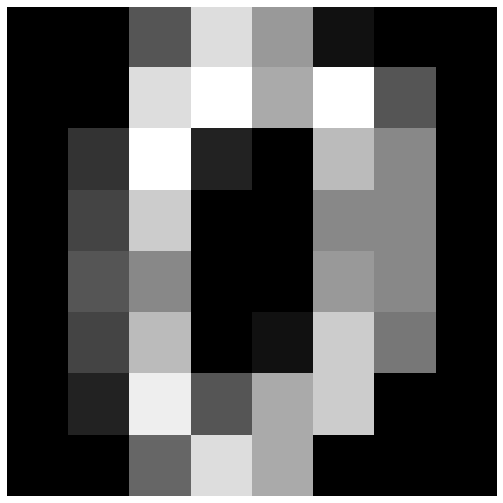

In [16]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

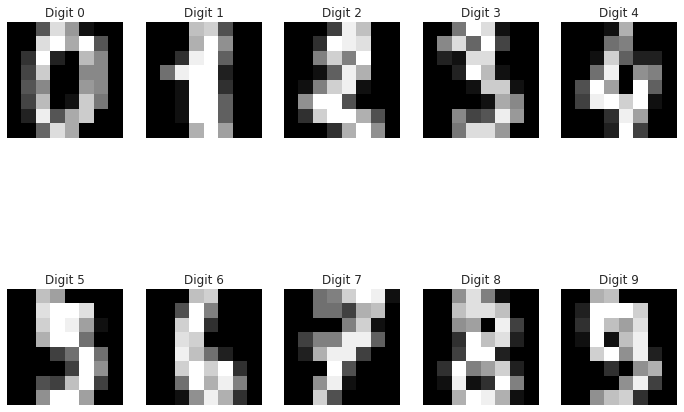

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

for i, dig in enumerate(np.unique(y)):
    axs.flatten()[i].imshow(X[list(np.where(y==dig))][0].reshape(8, 8).astype(int), cmap='gray')
    axs.flatten()[i].set_title("Digit " + str(dig))
    axs.flatten()[i].axis("off")
#     if i // 5 == 0:
#         image = X[list(np.where(y==dig))][0].reshape(8, 8).astype(int)
#         axs[i//5, i%5].imshow(image, cmap='gray')
#         axs[i//5, i%5].set_title("Digit " + str(dig))
#         axs[i//5, i%5].axis("off")
#     else:
#         image = X[list(np.where(y==dig))][0].reshape(8, 8).astype(int)
#         axs[i//5, i%5].imshow(image, cmap='gray')
#         axs[i//5, i%5].set_title("Digit " + str(dig))
#         axs[i//5, i%5].axis("off")
        


Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

   * метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure

In [18]:
def algorithm_selection(X, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния ('euclidean', 'manhattan', 'l1', 'l2', 'cosine', 'chebyshev', 'minkowski', 'canberra')
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')
    :return compare_dataframe: таблица с метриками кластеризации
    """
 
    compare_dic = {"distance": [], "linkage": [], "homogenity": [], "completeness": [], "v_measure": []}
    for dist in distances:
        for alg in algorithms:
            compare_dic["distance"].append(dist)
            compare_dic["linkage"].append(alg)
            agg_clus = AgglomerativeClustering(n_clusters=10, affinity=dist, linkage=alg)
            y_pred = agg_clus.fit_predict(X)
            hom, compl, v = homogeneity_completeness_v_measure(y, y_pred)
            compare_dic["homogenity"].append(hom)
            compare_dic["completeness"].append(compl)
            compare_dic["v_measure"].append(v)
            
    compare_dataframe = pd.DataFrame(compare_dic)
            
    return compare_dataframe

In [19]:
distances = ["euclidean", "manhattan", "cosine", "chebyshev", "minkowski", "canberra", "hamming"] # euclidean - l2, manhattan - l1
algorithms = ['average', 'single', 'complete']
metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']

In [20]:
compare_dataframe = algorithm_selection(X, distances=distances, algorithms=algorithms, metrics=metrics)

In [21]:
compare_dataframe

distance   linkage  homogenity  completeness  v_measure
0   euclidean   average    0.655393      0.782342   0.713263
1   euclidean    single    0.005056      0.273755   0.009929
2   euclidean  complete    0.590549      0.637772   0.613253
3   manhattan   average    0.566751      0.778942   0.656117
4   manhattan    single    0.005102      0.276237   0.010019
5   manhattan  complete    0.646372      0.686109   0.665648
6      cosine   average    0.648268      0.808762   0.719676
7      cosine    single    0.005050      0.273389   0.009916
8      cosine  complete    0.528727      0.577415   0.551999
9   chebyshev   average    0.769464      0.828645   0.797959
10  chebyshev    single    0.006129      0.281430   0.011996
11  chebyshev  complete    0.067111      0.412582   0.115444
12  minkowski   average    0.655393      0.782342   0.713263
13  minkowski    single    0.005056      0.273755   0.009929
14  minkowski  complete    0.590549      0.637772   0.613253
15   canberra   average    0.573860      0.779789   0.661161
16   canberra    single    0.006144      0.280506   0.012025
17   canberra  complete    0.528702      0.561588   0.544649
18    hamming   average    0.145290      0.752769   0.243569
19    hamming    single    0.005059      0.273918   0.009935
20    hamming  complete    0.479972      0.518721   0.498595

In [22]:
compare_dataframe.iloc[compare_dataframe[["homogenity", "completeness", "v_measure"]].sum(axis=1).idxmax()]

distance        chebyshev
linkage           average
homogenity       0.769464
completeness     0.828645
v_measure        0.797959
Name: 9, dtype: object

Simple method to check which one is the best - sum the metrics columns. According to this - chebyshev distance, average linkage is the best model. If we take a look at the table one more time to make sure - that actually seems to make sense.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [23]:
fc_data = pd.read_csv(join(DATA_PATH, "../data/flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [24]:
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [25]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [26]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [27]:
fc_data.isnull().sum()

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

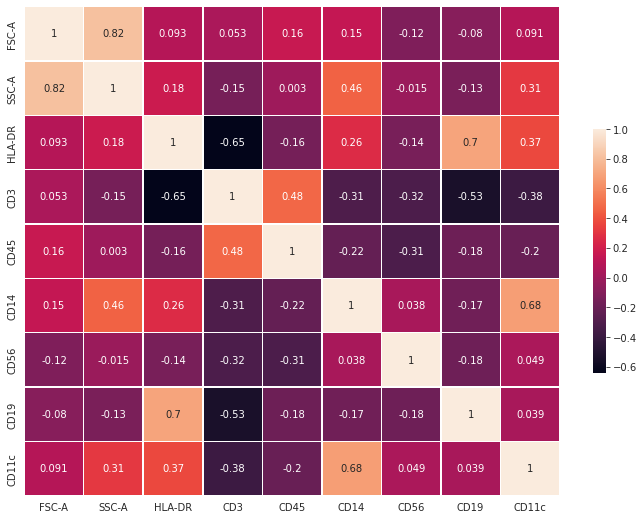

In [28]:
corr = fc_data.corr()
sns.heatmap(corr, annot=True, linewidths=0.5, cbar_kws={"shrink": 0.5});

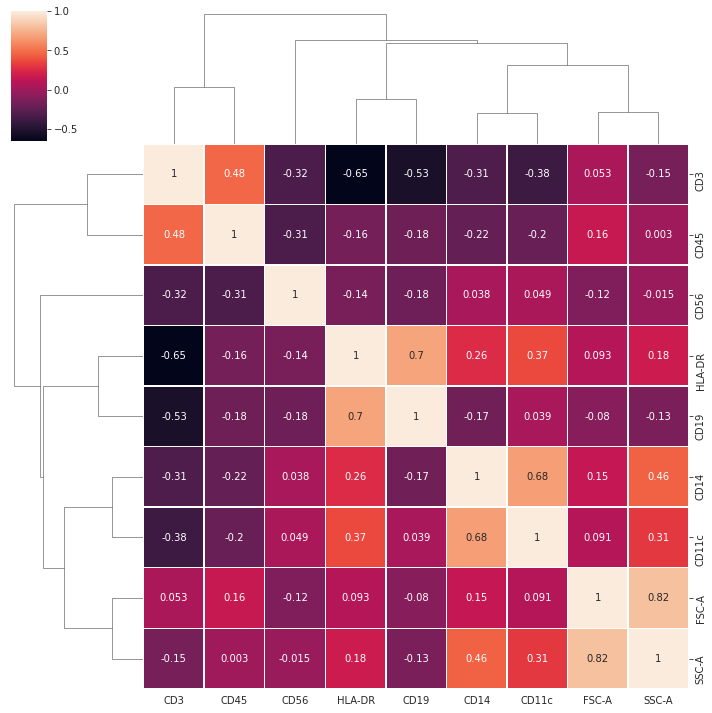

In [29]:
sns.clustermap(corr, annot=True, linewidths=0.5, cbar_kws={"shrink": 0.5});

In [30]:
unstacked_abs_corr = corr.abs().unstack()
unstacked_abs_corr.sort_values()[unstacked_abs_corr.sort_values() < 1][-10:]

CD3     CD19      0.530428
CD19    CD3       0.530428
CD3     HLA-DR    0.645041
HLA-DR  CD3       0.645041
CD11c   CD14      0.677559
CD14    CD11c     0.677559
HLA-DR  CD19      0.701287
CD19    HLA-DR    0.701287
FSC-A   SSC-A     0.817055
SSC-A   FSC-A     0.817055
dtype: float64

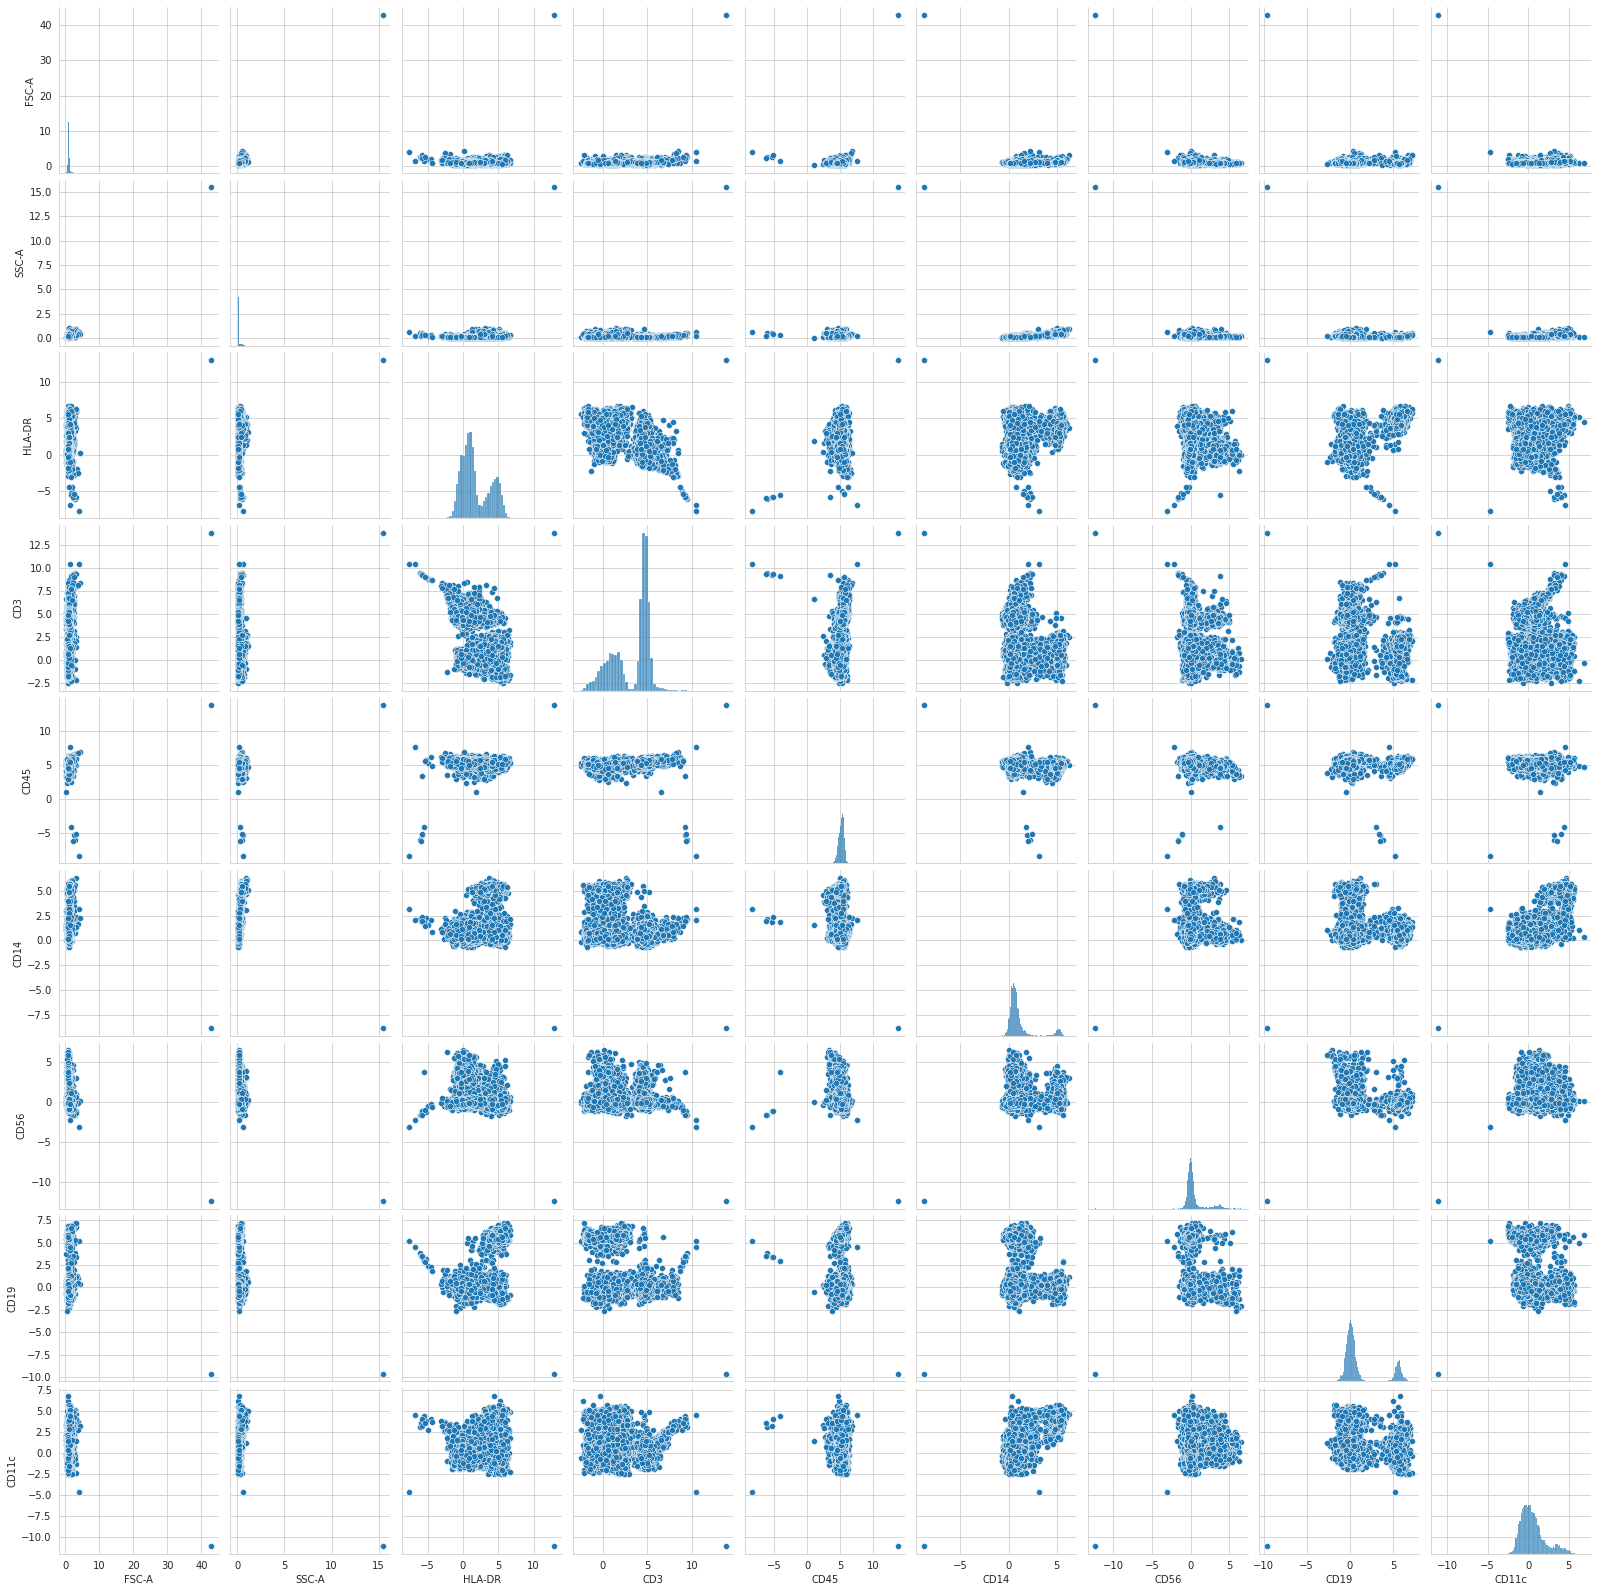

In [31]:
sns.pairplot(fc_data)

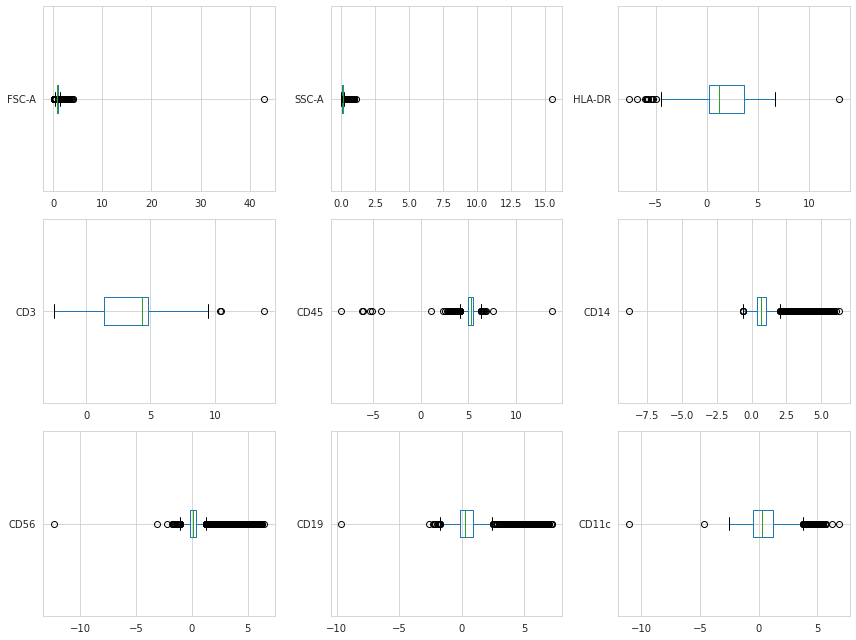

In [32]:
fig, axes = plt.subplots(3, 3)

for i, el in enumerate(list(fc_data.columns.values)):
    fc_data.boxplot(el, ax=axes.flatten()[i], vert=False)

plt.tight_layout()
plt.show()

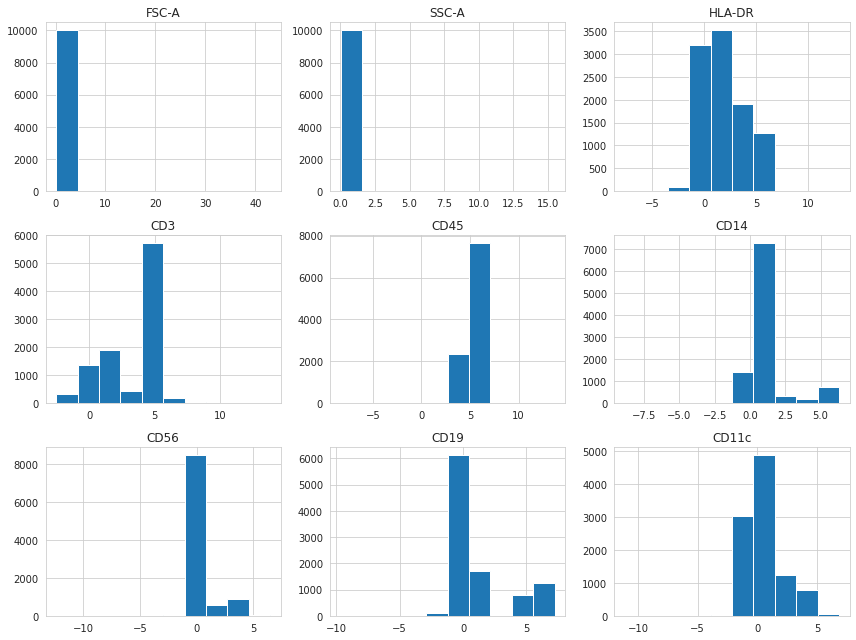

In [33]:
fig, axes = plt.subplots(3, 3)

for i, el in enumerate(list(fc_data.columns.values)):
    fc_data.hist(el, ax=axes.flatten()[i])

plt.tight_layout()
plt.show()

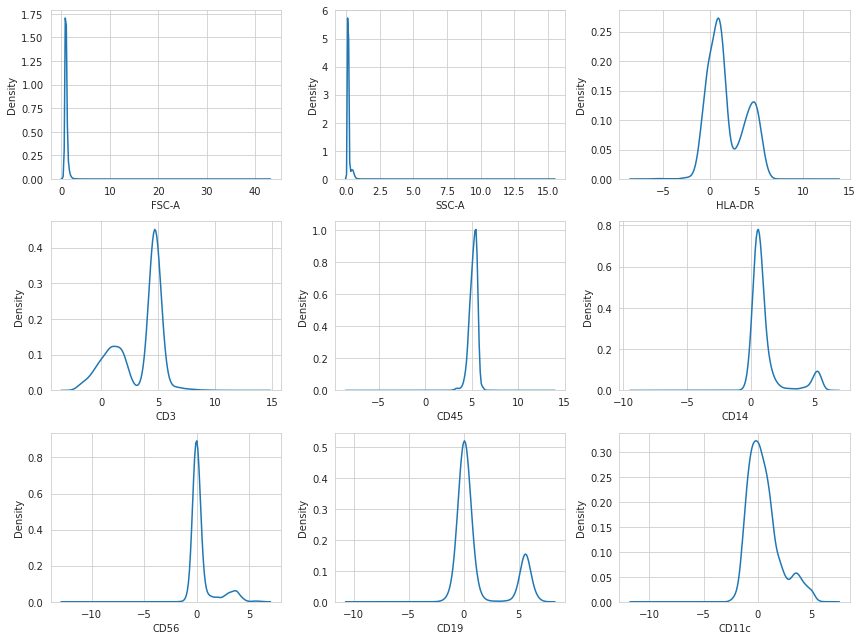

In [34]:
fig, axes = plt.subplots(3, 3)

for i, el in enumerate(list(fc_data.columns.values)):
    sns.kdeplot(fc_data[el], ax=axes.flatten()[i])

plt.tight_layout()
plt.show()

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [35]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: число соседей
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=SEED)
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

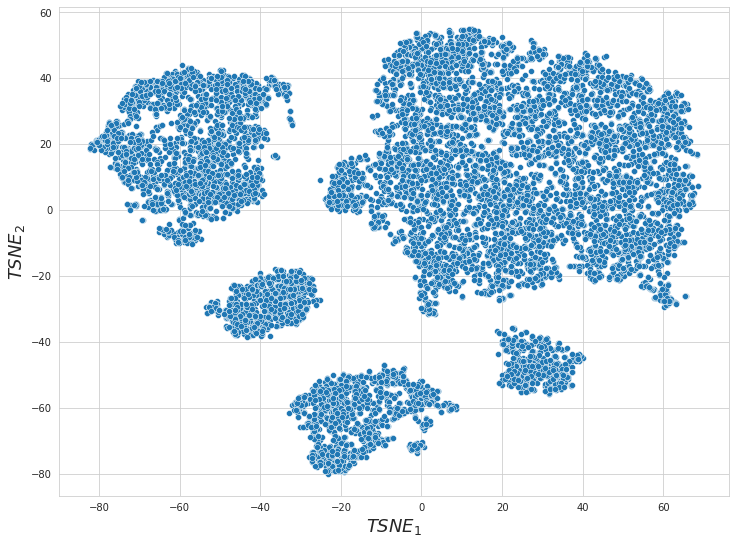

In [36]:
tsne_embedding_2D = plot_tsne(fc_data)

In [37]:
def plot_tsne_3D(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: число соседей
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=3, init=pca_embedding[:, :3], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity, random_state=SEED)
    tsne_embedding = tnse.fit_transform(pca_embedding)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("$TSNE_1$", fontsize=18)
    ax.set_ylabel("$TSNE_2$", fontsize=18)
    ax.set_zlabel("$TSNE_3$", fontsize=18)
    
    ax.scatter(tsne_embedding[:, 0], 
               tsne_embedding[:, 1], 
               tsne_embedding[:, 2],
               c=color, cmap="Pastel1")

    plt.show()
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding


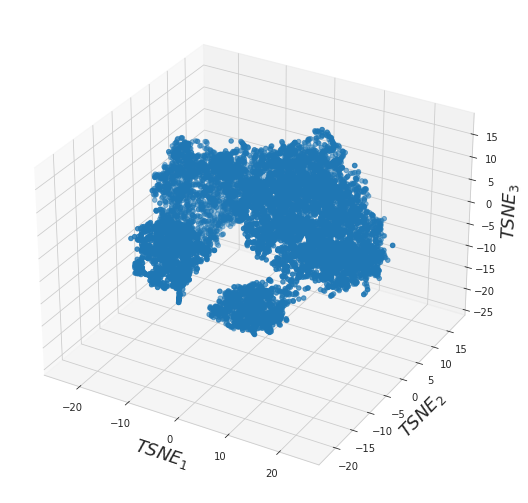

In [38]:
# %matplotlib notebook - to activate interactive 3D
tsne_embedding_3D = plot_tsne_3D(fc_data)

Based on the 2D and 3D plot - I see 5 clusters. Actually, there are 4 types of cells though.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Defining 2D and 3D plots:

In [39]:
def plot_2D(tsne_embedding_2D, clusters=None):
    sns.scatterplot(x=tsne_embedding_2D[:, 0],
                    y=tsne_embedding_2D[:, 1],
                    hue=clusters, palette="Pastel2")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
        

In [40]:
def plot_3D(tsne_embedding_3D, clusters=None):
   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("$TSNE_1$", fontsize=18)
    ax.set_ylabel("$TSNE_2$", fontsize=18)
    ax.set_zlabel("$TSNE_3$", fontsize=18)
    
    ax.scatter(tsne_embedding_3D[:, 0], 
               tsne_embedding_3D[:, 1], 
               tsne_embedding_3D[:, 2],
               c=clusters, cmap="Pastel2")

    plt.show()

## KMeans

In [41]:
kmeans = KMeans(n_clusters=4, random_state=SEED).fit(fc_data)
pred_labels = kmeans.predict(fc_data)

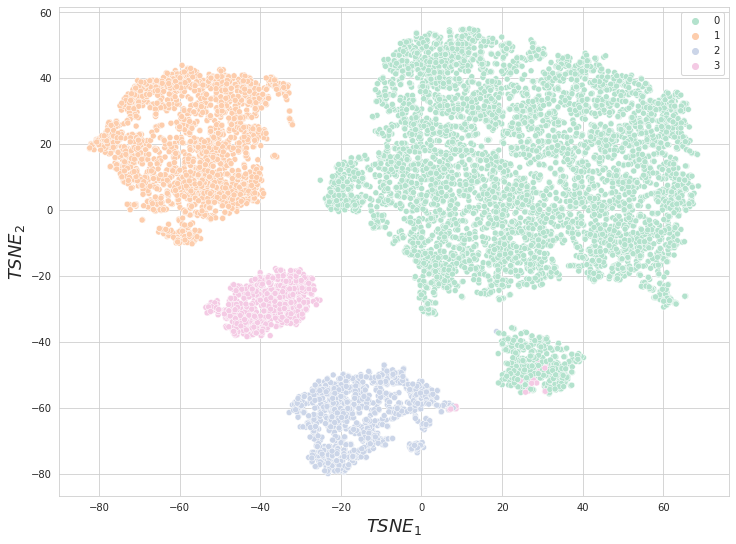

In [42]:
plot_2D(tsne_embedding_2D, pred_labels);

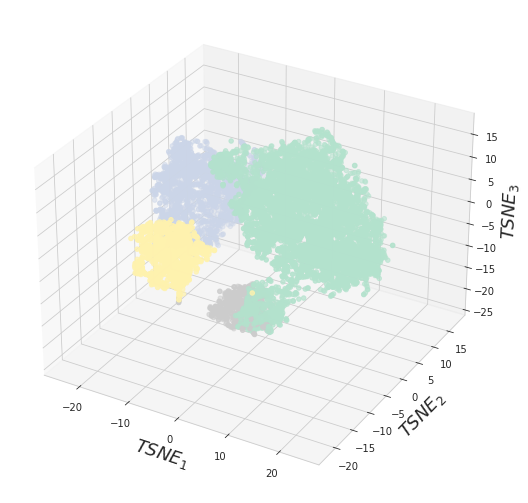

In [43]:
plot_3D(tsne_embedding_3D, pred_labels);

In [44]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6103014000983125


## MiniBatchKMeans

In [45]:
mini_kmeans = MiniBatchKMeans(n_clusters=4, random_state=SEED).fit(fc_data)
pred_labels = mini_kmeans.predict(fc_data)

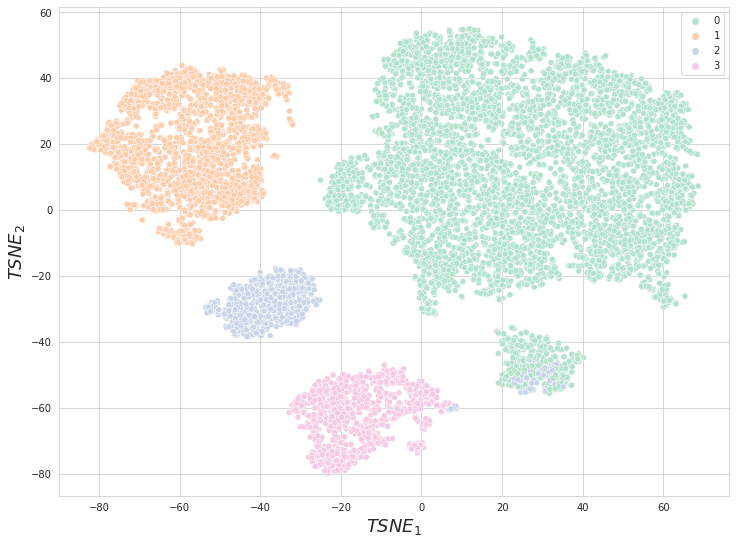

In [46]:
plot_2D(tsne_embedding_2D, pred_labels);

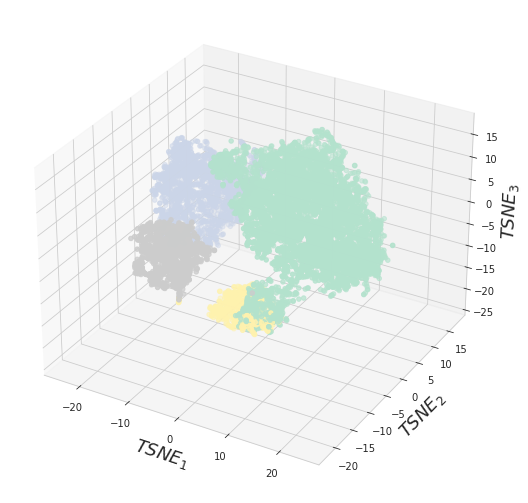

In [47]:
plot_3D(tsne_embedding_3D, pred_labels);

In [48]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6031910576321328


Silhouette Score for MiniBatchKMeans is even better than for KMeans.

## Agglomerative clustering

In [49]:
def algorithm_selection(X, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param pred_labels: предск. кластеры (n_samples)
        :param distances: список возможных метрик расстояния ('euclidean', 'manhattan', 'l1', 'l2', 'cosine', 'chebyshev', 'minkowski', 'canberra')
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')
    :return compare_dataframe: таблица с метриками кластеризации
    """
 
    compare_dic = {"distance": [], "linkage": [], "silhouette": []}
    for dist in distances:
        for alg in algorithms:
            compare_dic["distance"].append(dist)
            compare_dic["linkage"].append(alg)
            agg_clus = AgglomerativeClustering(n_clusters=4, affinity=dist, linkage=alg)
            y_pred = agg_clus.fit_predict(X)
            compare_dic["silhouette"].append(silhouette_score(X, y_pred))
            
    compare_dataframe = pd.DataFrame(compare_dic)
            
    return compare_dataframe

In [50]:
compare_df = algorithm_selection(fc_data, distances, algorithms, metrics)

In [51]:
compare_df

distance   linkage  silhouette
0   euclidean   average    0.654419
1   euclidean    single    0.654419
2   euclidean  complete    0.307133
3   manhattan   average    0.578442
4   manhattan    single    0.654419
5   manhattan  complete    0.578442
6      cosine   average    0.538403
7      cosine    single    0.654419
8      cosine  complete    0.519039
9   chebyshev   average    0.654419
10  chebyshev    single    0.654419
11  chebyshev  complete    0.496353
12  minkowski   average    0.654419
13  minkowski    single    0.654419
14  minkowski  complete    0.307133
15   canberra   average    0.224551
16   canberra    single    0.094073
17   canberra  complete    0.381371
18    hamming   average    0.024429
19    hamming    single    0.024429
20    hamming  complete    0.024429

In [52]:
compare_df.iloc[compare_df[["silhouette"]].sum(axis=1).idxmax()]

distance      euclidean
linkage         average
silhouette     0.654419
Name: 0, dtype: object

In [53]:
agg_clus = AgglomerativeClustering(n_clusters=4)
pred_labels = agg_clus.fit_predict(fc_data)

In [54]:
dir(agg_clus)
print(agg_clus.linkage, agg_clus.affinity)

ward euclidean


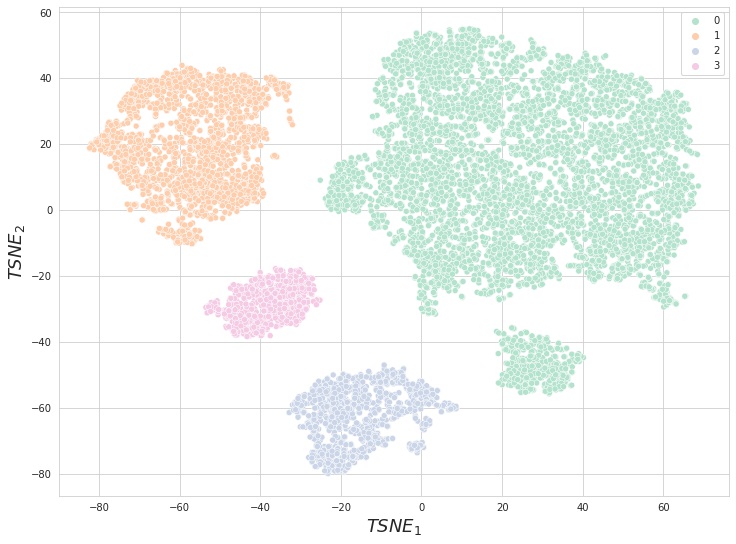

In [55]:
plot_2D(tsne_embedding_2D, pred_labels);

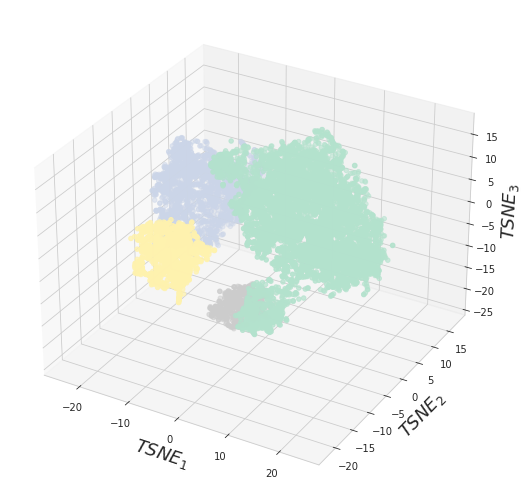

In [56]:
plot_3D(tsne_embedding_3D, pred_labels);

In [57]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6114468221314616


In [58]:
agg_clus = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
pred_labels = agg_clus.fit_predict(fc_data)

In [59]:
dir(agg_clus)
print(agg_clus.linkage, agg_clus.affinity)

average euclidean


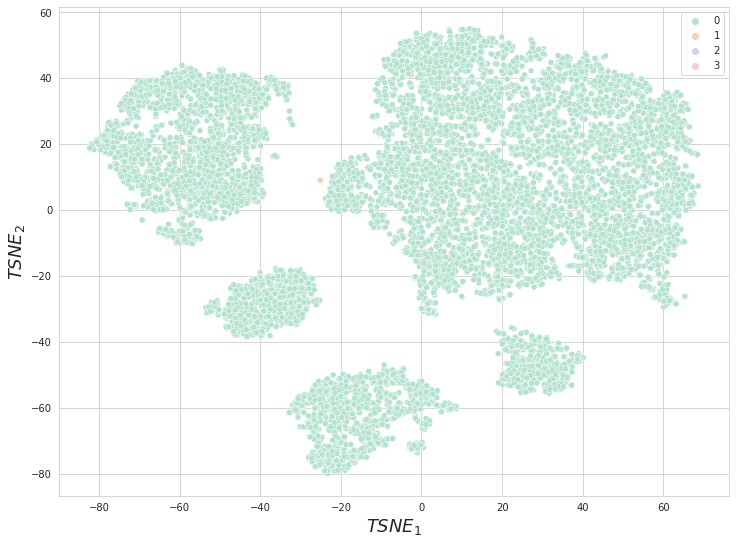

In [60]:
plot_2D(tsne_embedding_2D, pred_labels);

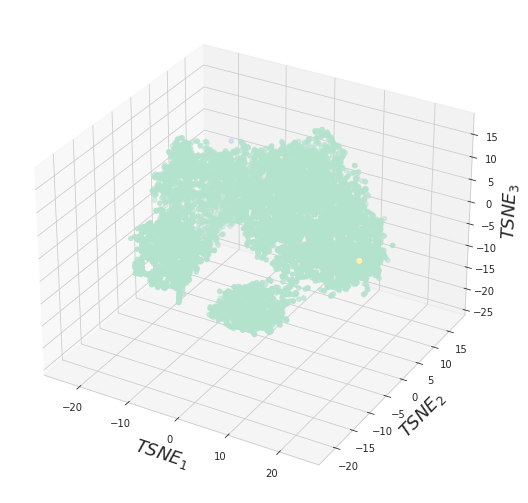

In [61]:
plot_3D(tsne_embedding_3D, pred_labels);

In [62]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6544189735692252


Странно...

## Birch

In [63]:
birch_clus = Birch(n_clusters=4)
pred_labels = birch_clus.fit_predict(fc_data)

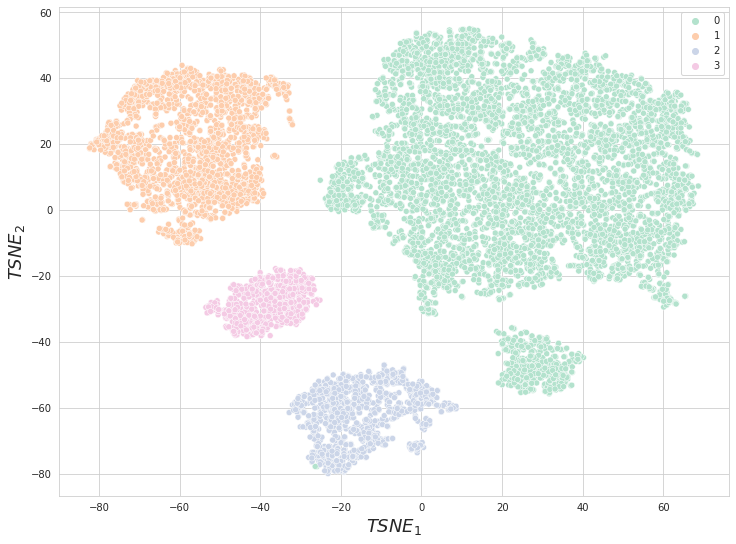

In [64]:
plot_2D(tsne_embedding_2D, pred_labels);

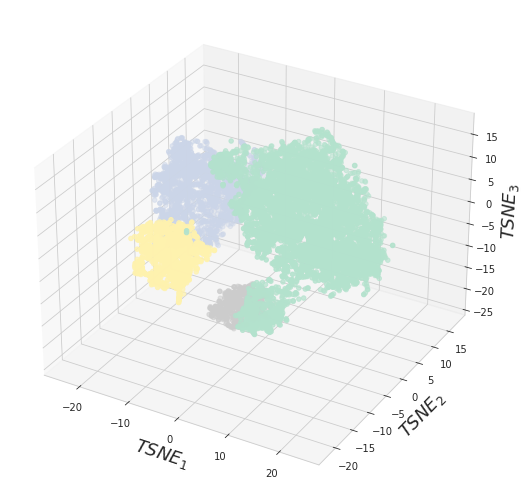

In [65]:
plot_3D(tsne_embedding_3D, pred_labels);

In [66]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.61128883177272


## DBSCAN

In [67]:
db_clus = DBSCAN(eps=2, min_samples=300)
pred_labels = db_clus.fit_predict(fc_data)

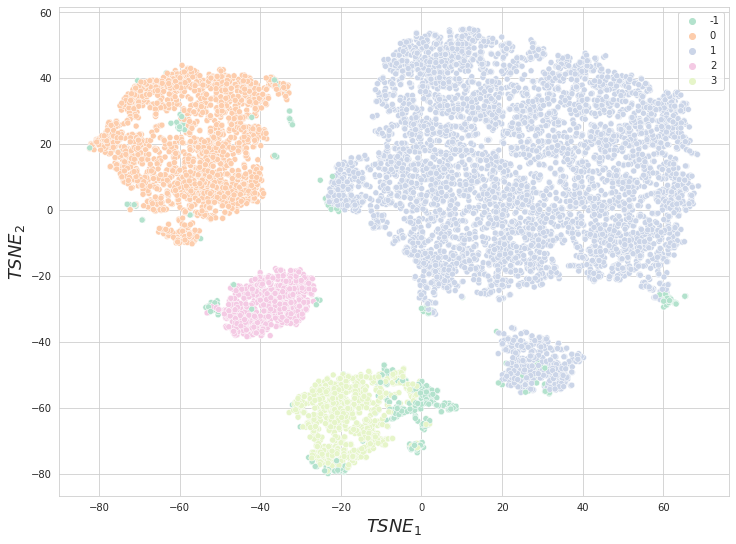

In [68]:
plot_2D(tsne_embedding_2D, pred_labels);

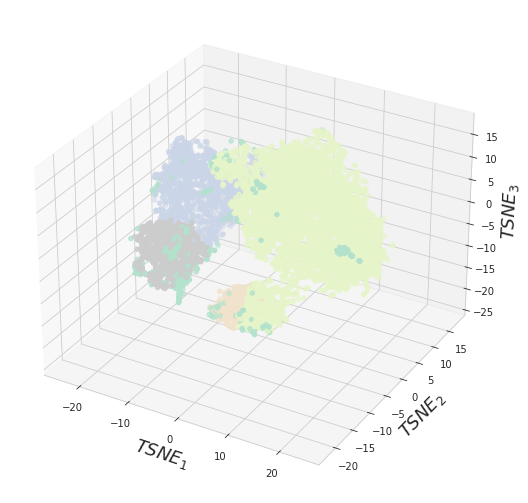

In [69]:
plot_3D(tsne_embedding_3D, pred_labels);

In [70]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.5822145144489316


## Mean Shift

In [71]:
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(fc_data, quantile=0.5, n_samples=len(fc_data)**2)

mean_clus = MeanShift(bandwidth=bandwidth)
pred_labels = mean_clus.fit_predict(fc_data)

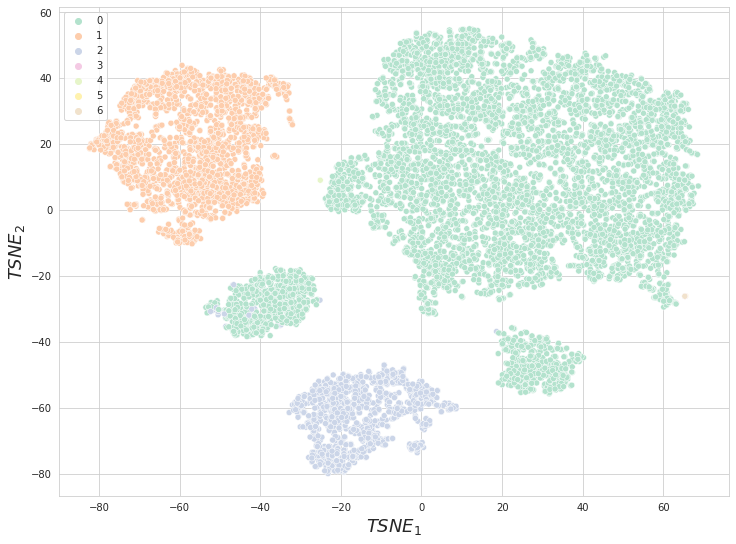

In [72]:
plot_2D(tsne_embedding_2D, pred_labels);

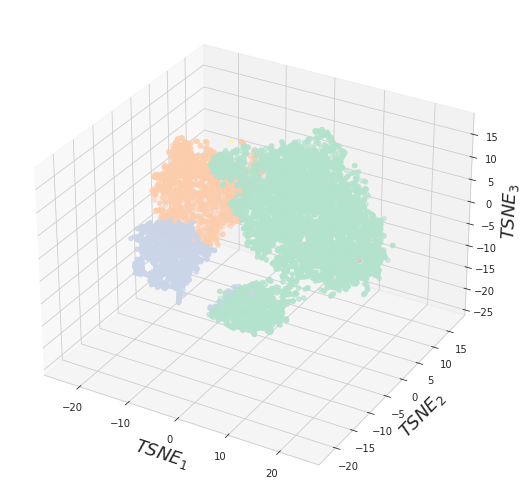

In [73]:
plot_3D(tsne_embedding_3D, pred_labels);

In [74]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6097741278568498


## OPTICS

In [75]:
opt_clus = OPTICS(min_samples=30, max_eps=2)
pred_labels = opt_clus.fit_predict(fc_data)

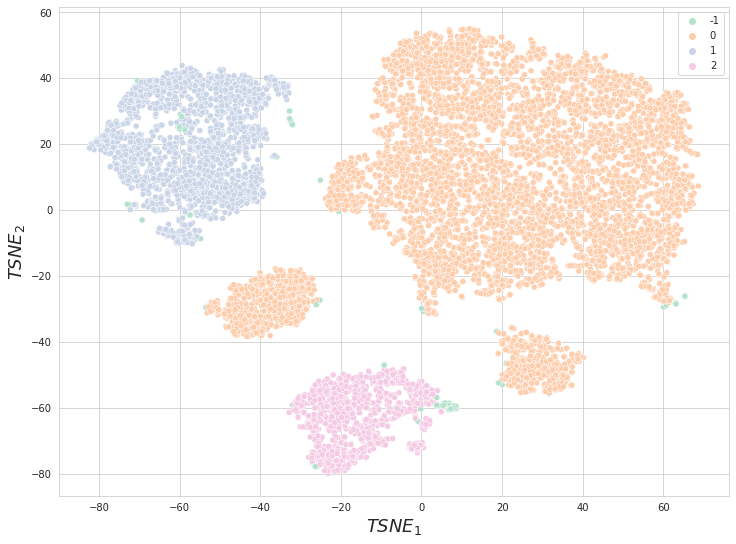

In [76]:
plot_2D(tsne_embedding_2D, pred_labels);

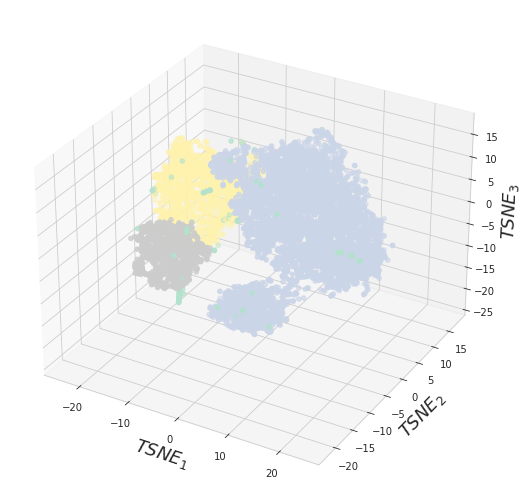

In [77]:
plot_3D(tsne_embedding_3D, pred_labels);

In [78]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.6066776960062027


## Spectral Clustering

In [79]:
spec_clus = SpectralClustering(n_clusters=5)
pred_labels = spec_clus.fit_predict(fc_data)

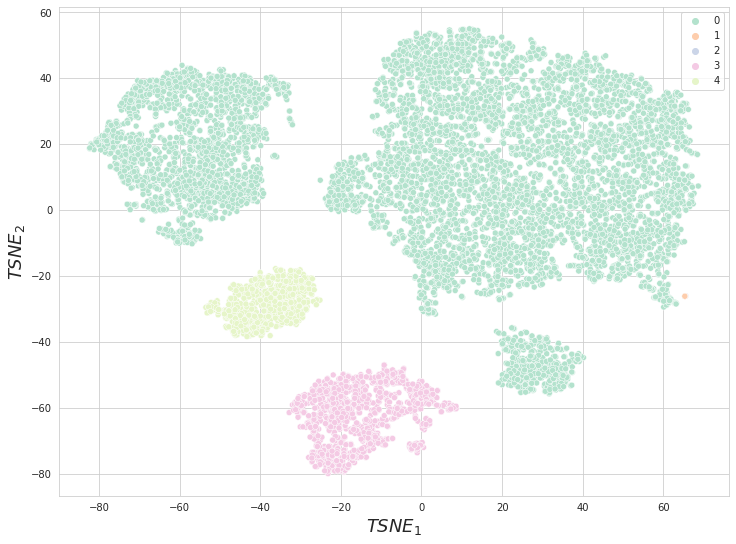

In [80]:
plot_2D(tsne_embedding_2D, pred_labels);

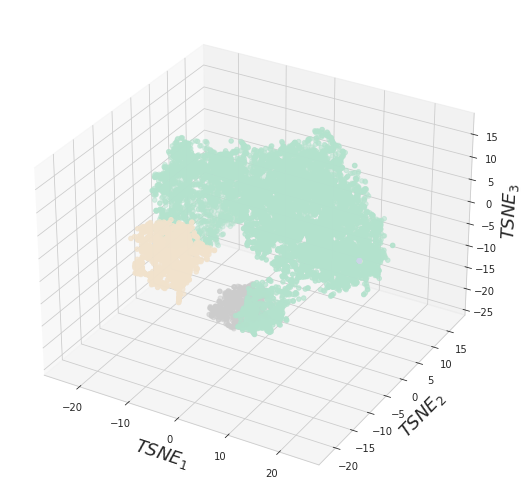

In [81]:
plot_3D(tsne_embedding_3D, pred_labels);

In [82]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.36572890717064


## Gaussian Mixture

In [83]:
gauss_clus = GaussianMixture(n_components=4)
pred_labels = gauss_clus.fit_predict(fc_data)

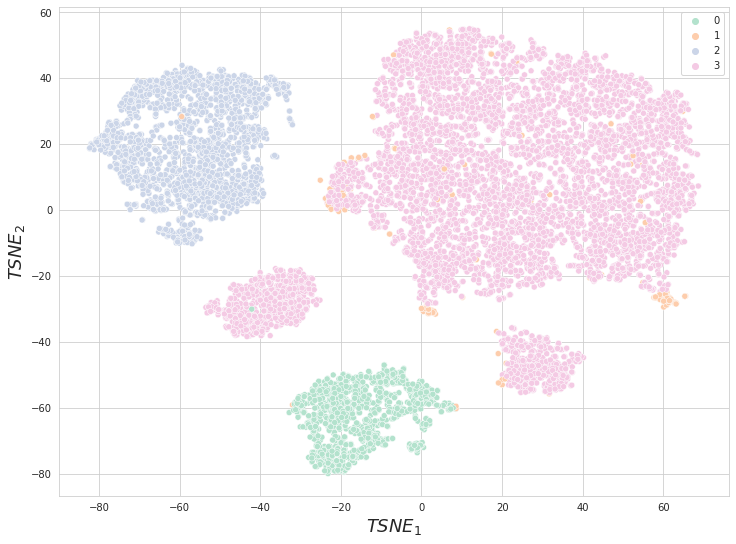

In [84]:
plot_2D(tsne_embedding_2D, pred_labels);

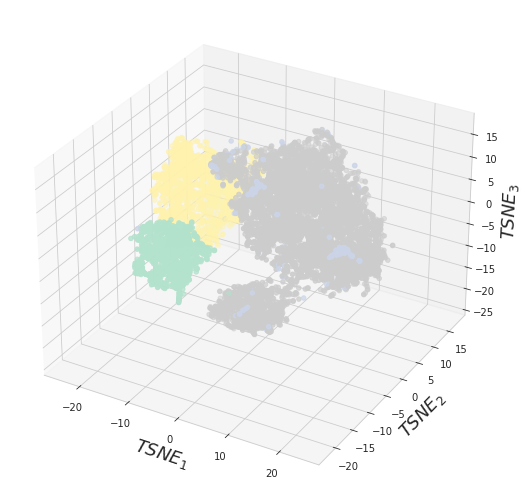

In [85]:
plot_3D(tsne_embedding_3D, pred_labels);

In [86]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.5008825131492034


## Affinity propagation

Does not need pre-determination of the cluster number.

In [87]:
aff_clus = AffinityPropagation(damping=0.8, max_iter=200, random_state=SEED)
pred_labels = aff_clus.fit_predict(fc_data)

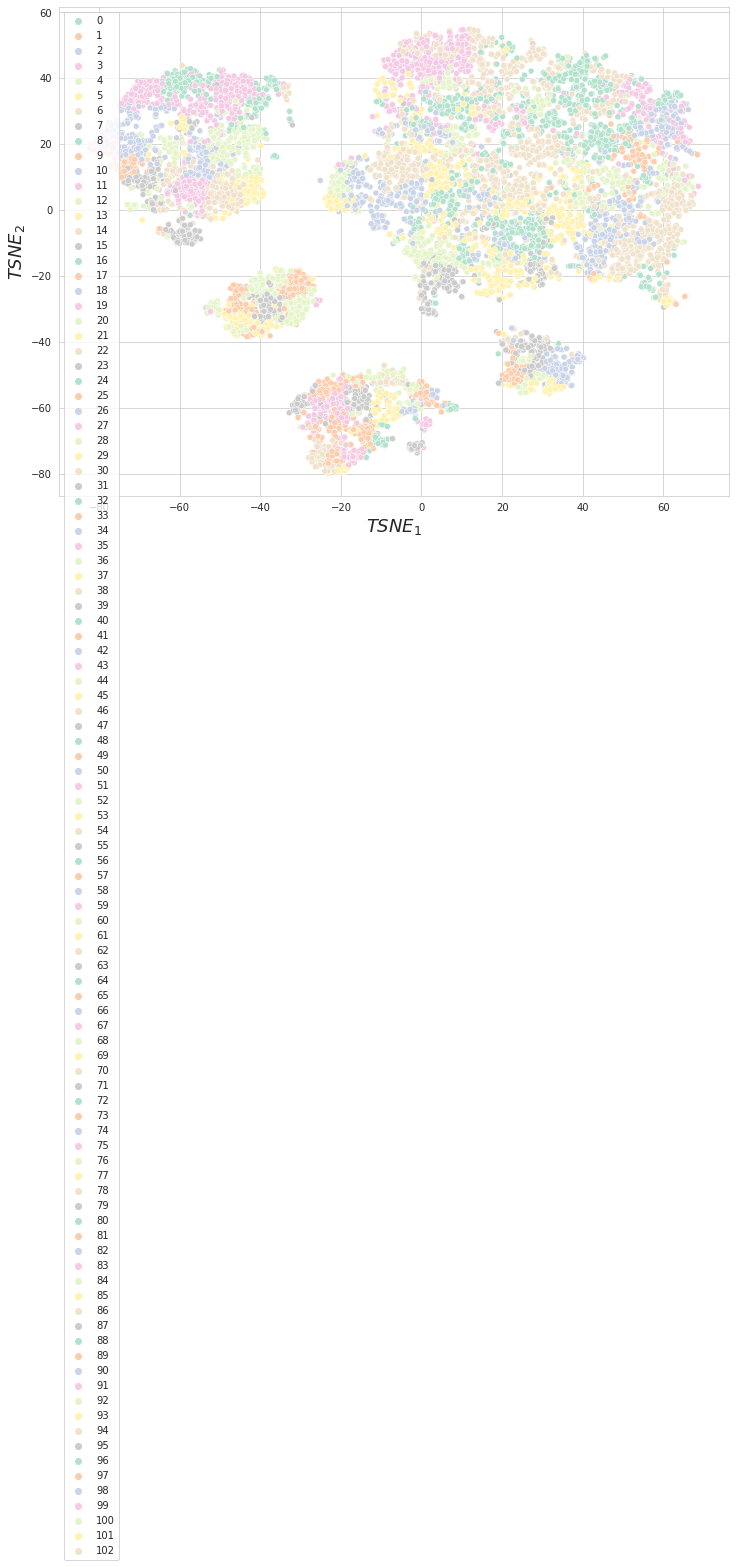

In [88]:
plot_2D(tsne_embedding_2D, pred_labels);

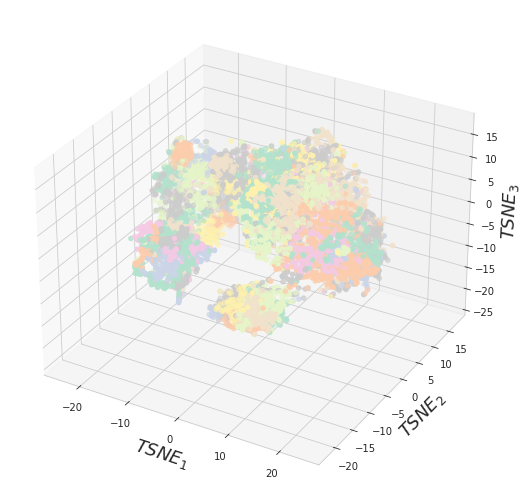

In [89]:
plot_3D(tsne_embedding_3D, pred_labels);

In [90]:
print(f"Silhouette Score: {silhouette_score(fc_data, pred_labels)}")

Silhouette Score: 0.10586156396195706


Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Да, с Agglomerative Clustering (Silhouette Score: 0.6114468221314616) и Birch (Silhouette Score: 0.612029406290045
) (DBSCAN тоже более или менее).

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

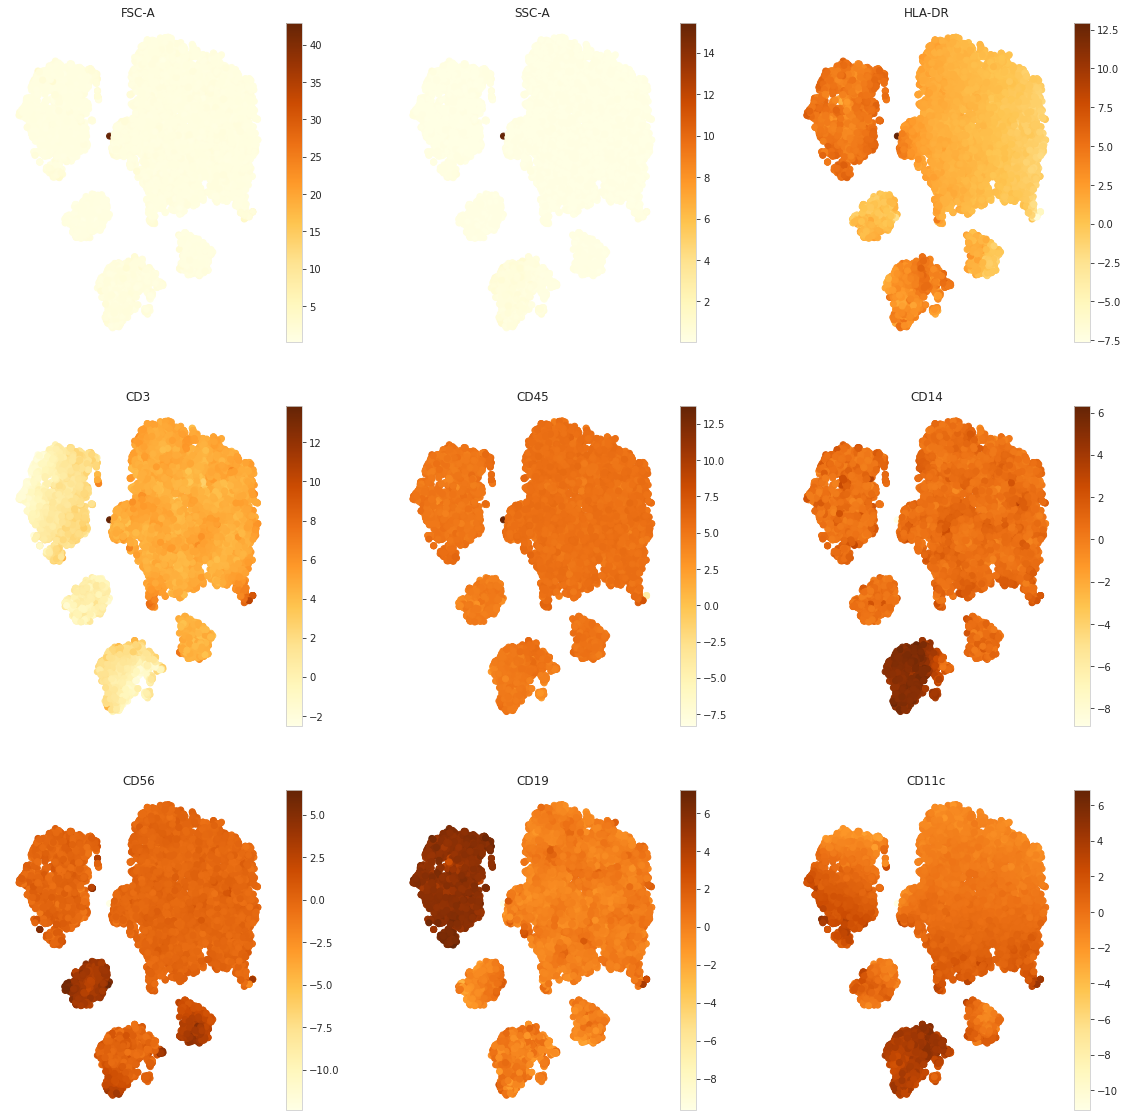

In [91]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_embedding_2D[:, 0], tsne_embedding_2D[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Markers that are different for different cell types according to the coloring:
* [HLA-DR](https://en.wikipedia.org/wiki/HLA-DR) -  MHC class II cell surface receptor, ligand for T-cell receptor
* [CD3](https://en.wikipedia.org/wiki/CD3_(immunology)) - T cell co-receptor that is involved in activating both the cytotoxic T cell
* [CD14](https://en.wikipedia.org/wiki/CD14) - made by macrophages
* [CD56](https://en.wikipedia.org/wiki/Neural_cell_adhesion_molecule) - homophilic binding glycoprotein expressed on the surface of neurons, glia and skeletal muscle
* [CD19](https://en.wikipedia.org/wiki/CD19) - B-lymphocyte antigen CD19
* [CD11c](https://en.wikipedia.org/wiki/Integrin_alpha_X) - integrin alpha X chain protein. Integrins are heterodimeric integral membrane proteins composed of an alpha chain and a beta chain. This protein combines with the beta 2 chain (ITGB2) to form a leukocyte-specific integrin referred to as inactivated-C3b (iC3b) receptor 4 (CR4), high levels on most human dendritic cells, but also on monocytes, macrophages, neutrophils, and some B cells 

## Birch

In [92]:
birch_clus = Birch(n_clusters=4)
pred_labels = birch_clus.fit_predict(fc_data)

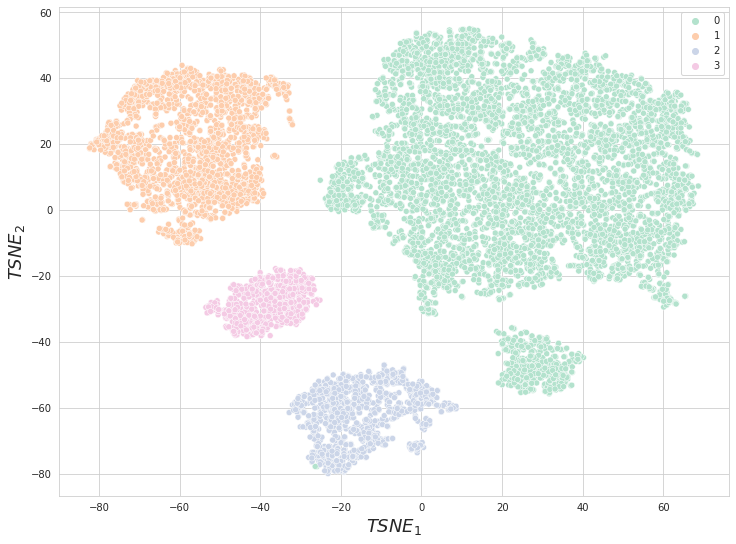

In [93]:
plot_2D(tsne_embedding_2D, pred_labels);

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [94]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Monocytes", 
                         3: "Other cells"}

In [95]:
labeled_fc_data = fc_data.assign(Population=birch_clus.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [96]:
labeled_fc_data["Population"].value_counts()

T_cells        6233
B_cells        2035
Monocytes      1097
Other cells     635
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [97]:
labeled_fc_data.to_csv('../data/results.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

## Decision Trees

In [98]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data["Population"]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [100]:
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

f1_score: 	0.9987


In [101]:
cls.classes_

array(['B_cells', 'Monocytes', 'Other cells', 'T_cells'], dtype=object)

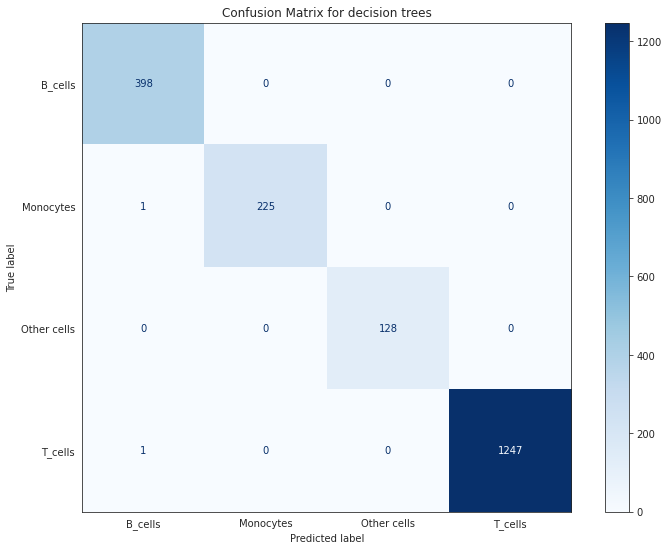

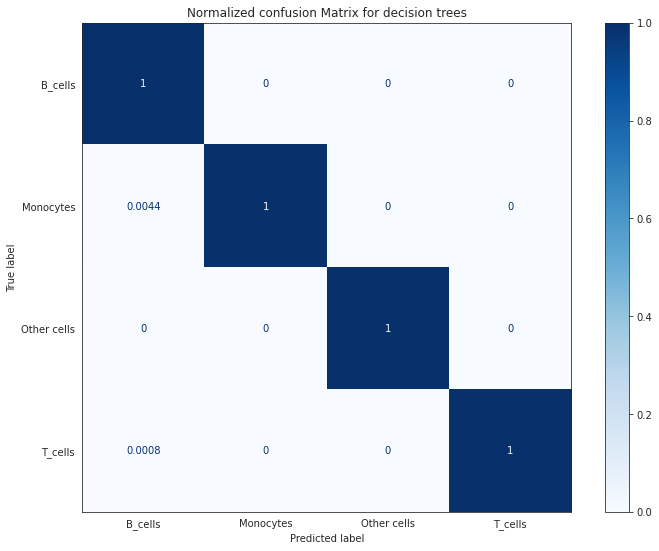

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay

# scikit-learn vers. 1.0.2

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues
    )
disp.ax_.set_title("Confusion Matrix for decision trees")

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues,
        normalize='true'
    )
disp.ax_.set_title("Normalized confusion Matrix for decision trees");

## Random Forest

In [129]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data["Population"]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [131]:
cls = Pipeline(steps=[('scaler', StandardScaler()),
                      ('classifier', RandomForestClassifier())])

cls.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

f1_score: 	1.0


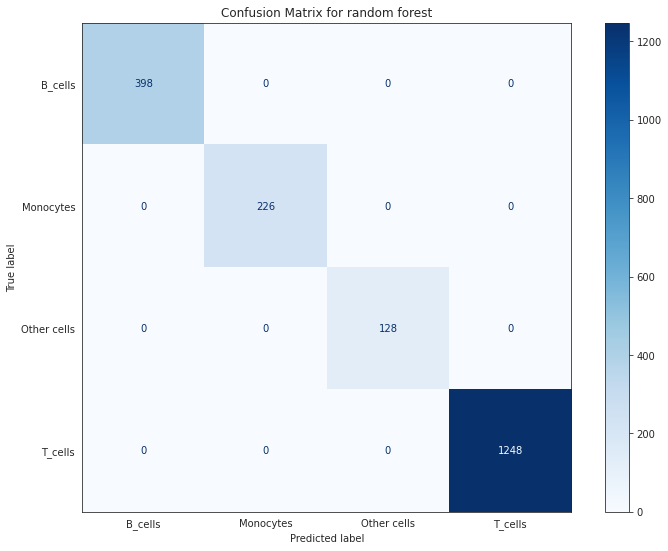

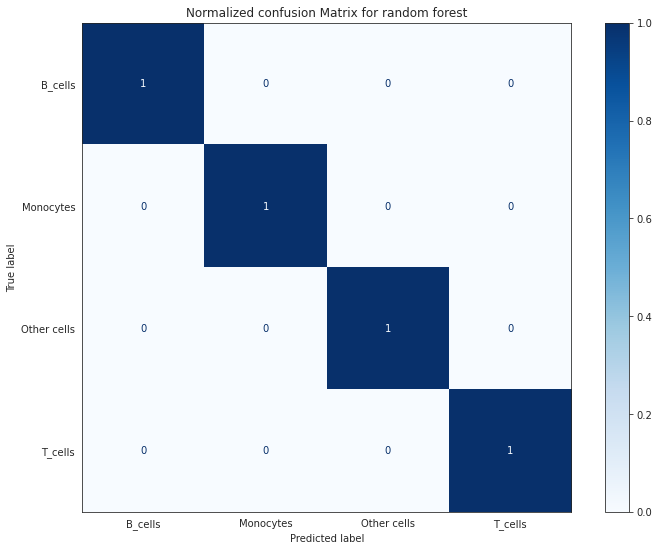

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay

# scikit-learn vers. 1.0.2

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues
    )
disp.ax_.set_title("Confusion Matrix for random forest")

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues,
        normalize='true'
    )
disp.ax_.set_title("Normalized confusion Matrix for random forest");

## KNN

In [134]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data["Population"]

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [136]:
cls = Pipeline(steps=[('scaler', StandardScaler()),
                      ('classifier', KNeighborsClassifier())])

cls.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

f1_score: 	1.0


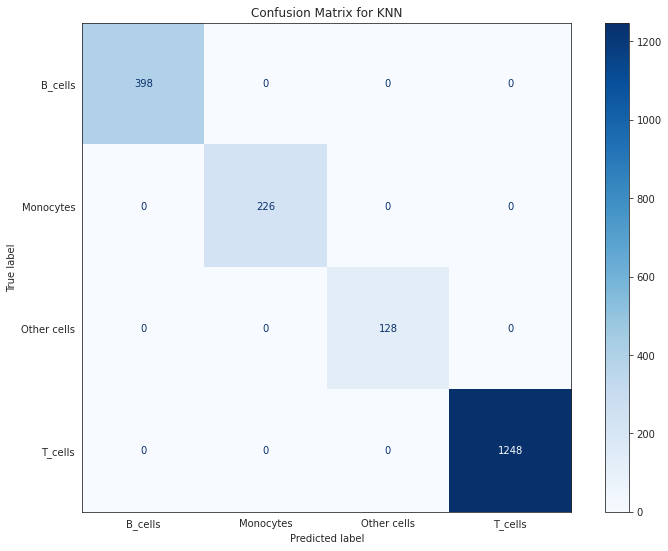

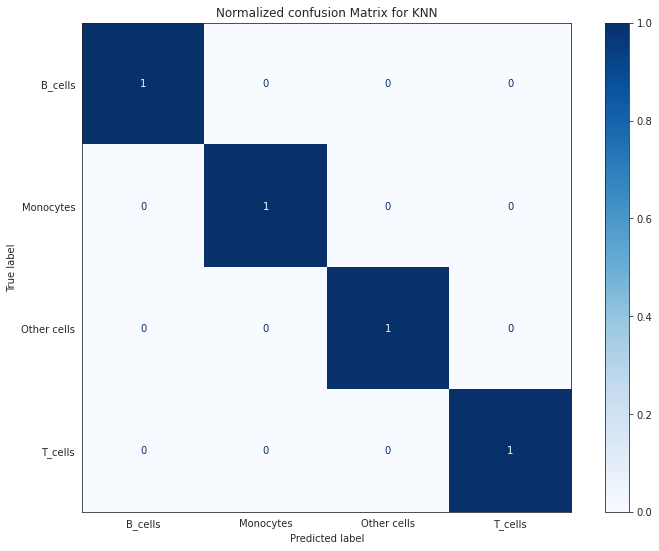

In [137]:
from sklearn.metrics import ConfusionMatrixDisplay

# scikit-learn vers. 1.0.2

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues
    )
disp.ax_.set_title("Confusion Matrix for KNN")

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues,
        normalize='true'
    )
disp.ax_.set_title("Normalized confusion Matrix for KNN");

## LogisticRegression

In [138]:
X = labeled_fc_data.drop("Population", axis=1)
y = labeled_fc_data["Population"]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [144]:
cls = Pipeline(steps=[('scaler', StandardScaler()),
                      ('classifier', LogisticRegression(max_iter=1000))])

cls.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'f1_score: \t{round(f1_score(y_test, y_pred, average="macro"), 4)}')

f1_score: 	1.0


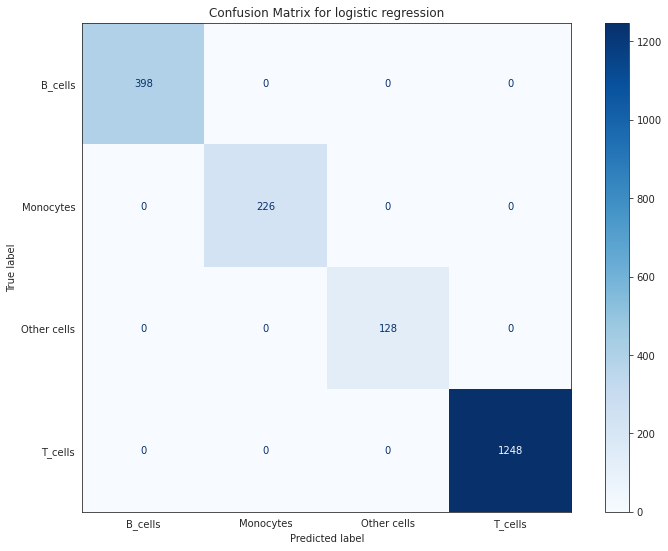

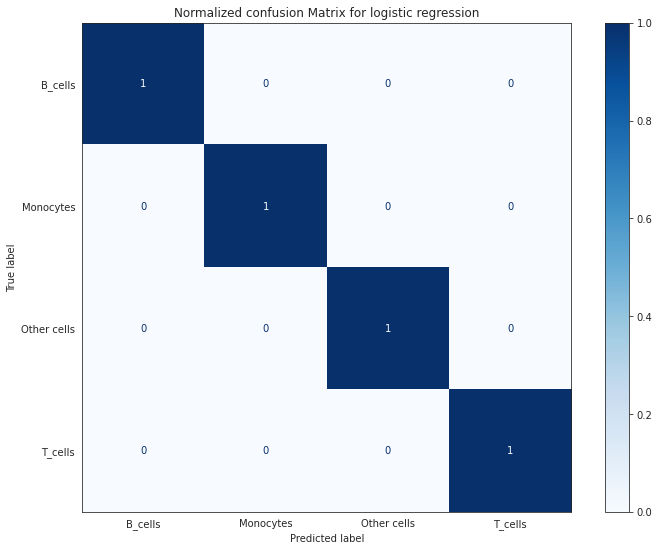

In [148]:
from sklearn.metrics import ConfusionMatrixDisplay

# scikit-learn vers. 1.0.2

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues
    )
disp.ax_.set_title("Confusion Matrix for logistic regression")

sns.set_style("white")
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=np.unique(y),
        cmap=plt.cm.Blues,
        normalize='true'
    )
disp.ax_.set_title("Normalized confusion Matrix for logistic regression");

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Luzern, Switzerland

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

It was okay.